## Notebook 02a: Understanding the sub-sevir Deep Learning Classification and Regression Models using Saliency


<div class="alert alert-block alert-danger"><b>Warning: </b> Before running this notebook, run the download_deep.ipynb notebook. That notebook will download the data and models used in this notebook. </div>


### Goal: Interogate the pre-trained classification and regression CNN models using Saliency

#### Background

In a [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_01a_ClassificationExplainability.ipynb), we interogated traditional ML models trained on manually engineered features from the sub-SEVIR dataset. We determined the top features, the relationships learned, and even explored explainability for individual predictions. For example, we found that spatial-maximum VIL and spatial-minimum IR temperature were the top features and the learned relationships matched with our physical intuition. In this notebook, we will try and understand convolutional neural networks that were trained on the identical tasks as the traditional ML models:
1. Does the image contain a lightning flash? 
2. How many lightning flashes are occuring in this image? 

The machine learning models here are trained as part of a paper that is in prep for WAF (Chase et al. "A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks"). To be explicit, we assume the GOES Lightning Mapper (GLM) observations are unavailable and we need to use the other measurements (e.g., infrared brightness temperature) as features to estimate if there are lightning flashes (i.e., classification), and how many of them are there (i.e., regression).

These are the same tasks as [Chase et al. (2022)](https://arxiv.org/abs/2204.07492), so see that paper if you want perspective. We also discussed these ideas on slide 33 - 37 in the Day 2 slides. 



### Primary Tasks: 
Use Saliency to explain the deep learning model 

### Seconday Tasks:
1. Explore different ways to visualize Saliency values
2. Compare the regression-based Saliency against the classification-based Saliency


In this notebook, you'll notice color-coded boxes, which may provide optional tasks, questions to discuss, or warnings. Here is the color-coding breakdown: 
* <span style="color:blue">Blue Box</span> = Question to discuss
* <span style="color:red">Red Box</span> = Warning/Caution
* <span style="color:gold">Yellow Box</span> = Optional task to perform 
* <span style="color:green">Green Box</span> = Useful Tip or Reminder


### Authors
* Randy Chase (OU/AI2ES) [email: randychase 'at' ou.edu; twitter: @dopplerchase]
* Montgomery Flora (CIWRO/NSSL) [email: monte.flora 'at' noaa.gov; twitter: @MontePhD]

### Import the neccesary third-party packages

In [1]:
!echo 'installing saliency'
!pip install saliency
!echo 'Done'

installing saliency
Done


In [2]:
class_idx_str = 'class_idx_str'
call_model_args = {class_idx_str: 0}
def call_model_function_class(images, call_model_args=None, expected_keys='INPUT_OUTPUT_GRADIENTS'):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model_class(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model_class(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

def call_model_function_reg(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model_reg(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model_reg(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [3]:
#load model 
import tensorflow as tf 
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import cmocean

# Add ../scripts to our path so we can import functions from there.
import sys,os
sys.path.append('../scripts') 
from deep_util import get_group_idx, get_groups, show_sample, make_plot, standardanom
from deep_util import make_plot_saliency
from util import unscale_data
from plotting_config import deep_display_feature_names, deep_color_dict
from deep_perm_imp import ImagePermI


from custom_metrics import *

#log the metrics so tensorflow can find them 
custom_objects = {'ConditionalMeanAbsoluteError': ConditionalMeanAbsoluteError,
                    'ConditionalMeanError': ConditionalMeanError,
                    'ConditionalRootMeanSquaredError':ConditionalRootMeanSquaredError,
                    'MeanError': MeanError,
                    'MaxCriticalSuccessIndex':MaxCriticalSuccessIndex}

2022-06-24 12:31:37.884279: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data.

The data has been pre-split into training, validation, and testing datasets. We will load in the `sub-SEVIR` dataset here and plot an example image. The example image is a strong convective event with plenty of lightning.

/Users/monte.flora/miniconda3/envs/ai2es/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


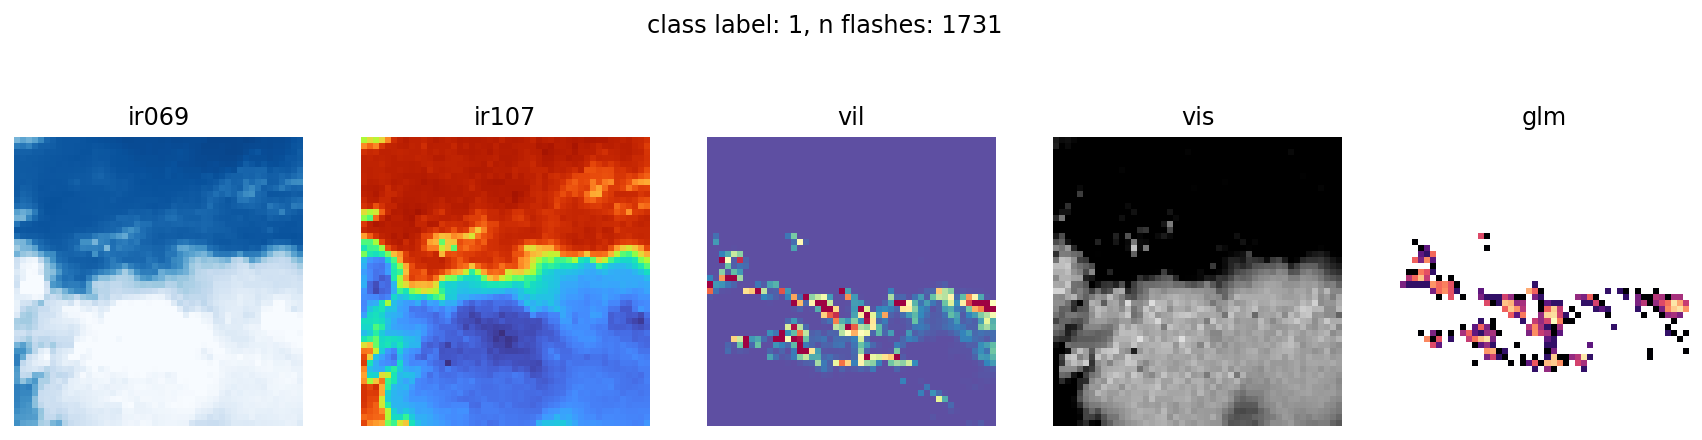

In [4]:
%config InlineBackend.figure_format = 'retina'

ds_train = xr.open_dataset('../datasets/sub-sevir-train.zarr', engine='zarr')
ds_val = xr.open_dataset('../datasets/sub-sevir-val.zarr', engine='zarr')
ds_test = xr.open_dataset('../datasets/sub-sevir-test.zarr', engine='zarr')

#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['S841009'])

#plot this example with a plotter function I have defined 
show_sample(ds_sample.isel(n_samples=11))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=11).features.values 

### Load the DL models.

Now that we have some data, let's load in the pretrained CNNs.

In [5]:
#load classification model 
cnn_class= tf.keras.models.load_model('../models/sub-sevir-cnn-class-1d.h5',
                                                 custom_objects=custom_objects)

#XAI wants to see the true loss, not the sigmoid(loss), so we need to remove the 
#sigmoid that is built in the model  
cnn_class.layers[-1].activation = tf.keras.activations.linear

#we also need to see the output of the last convolutional layer
conv_layer = cnn_class.get_layer('conv2d_1')

#link it up 
model_class = tf.keras.models.Model([cnn_class.inputs], [conv_layer.output, cnn_class.output])

#load regression model 
cnn_reg= tf.keras.models.load_model('../models/sub-sevir-cnn-reg-1d.h5',
                                                 custom_objects=custom_objects)

#we also need to see the output of the last convolutional layer
conv_layer = cnn_reg.get_layer('conv2d_1')

#link it up 
model_reg = tf.keras.models.Model([cnn_reg.inputs], [conv_layer.output, cnn_reg.output])

## Task 1 . Using Saliency to understand individual images

### Strong Convection Example

For this example, the classification model is confident there is lightning (~100%), and the regression model predicts more than 700 flashes (over 1700 flashes in reality). 

### i. Classification
This is a confident prediction from the model, with an output probability of effectively 1 (i.e., 100% confident there is lightning in the image)

The `make_plot` function plots the original images with the Saliency values overlaid. To improve the visualizations, we can use `mask_thresh` to only highlight higher Saliency values (identical functionality as in the SHAP notebooks). 


<div class="alert alert-block alert-success"><b>Interpreting Saliency: </b> Higher saliency values is which pixel the end prediction is more "sensitive" to. Saliency values typically identify edges or boundaries in the image. Saliency values indicate whether the end prediction is sensitive to local changes, but it does indicate if that whether pixels in that region contribute to the end prediction.  </div>


In this first example, we will examine the raw, vanilla saliency map. The raw map does highlight clound boundaries, but it is noisy and difficult to interpret. 

In [6]:
import saliency.core as saliency

def get_saliency(im, mode):
    """
    Parameters:
    ----------------
    im : input image (ny, nx, n_channels)
    mode : 'classification' or 'regression'
    
    Returns
    ----------------
    saliency_map : raw saliency map (ny, nx)
    smooth_saliency : smoothed saliency map (ny, nx)
    """
    # Construct the saliency object. This alone doesn't do anthing.
    gradient_saliency = saliency.GradientSaliency()

    arg = call_model_function_class if mode == 'classification' else call_model_function_reg
    
    # Compute the vanilla mask and the smoothed mask.
    saliency_map = gradient_saliency.GetMask(im, arg, call_model_args)
    smooth_saliency = gradient_saliency.GetSmoothedMask(im, arg, call_model_args, nsamples=1000)
    
    return saliency_map, smooth_saliency

In [7]:
# Compute the classification saliency maps
saliency_map_class, smooth_saliency_class = get_saliency(im, mode='classification')

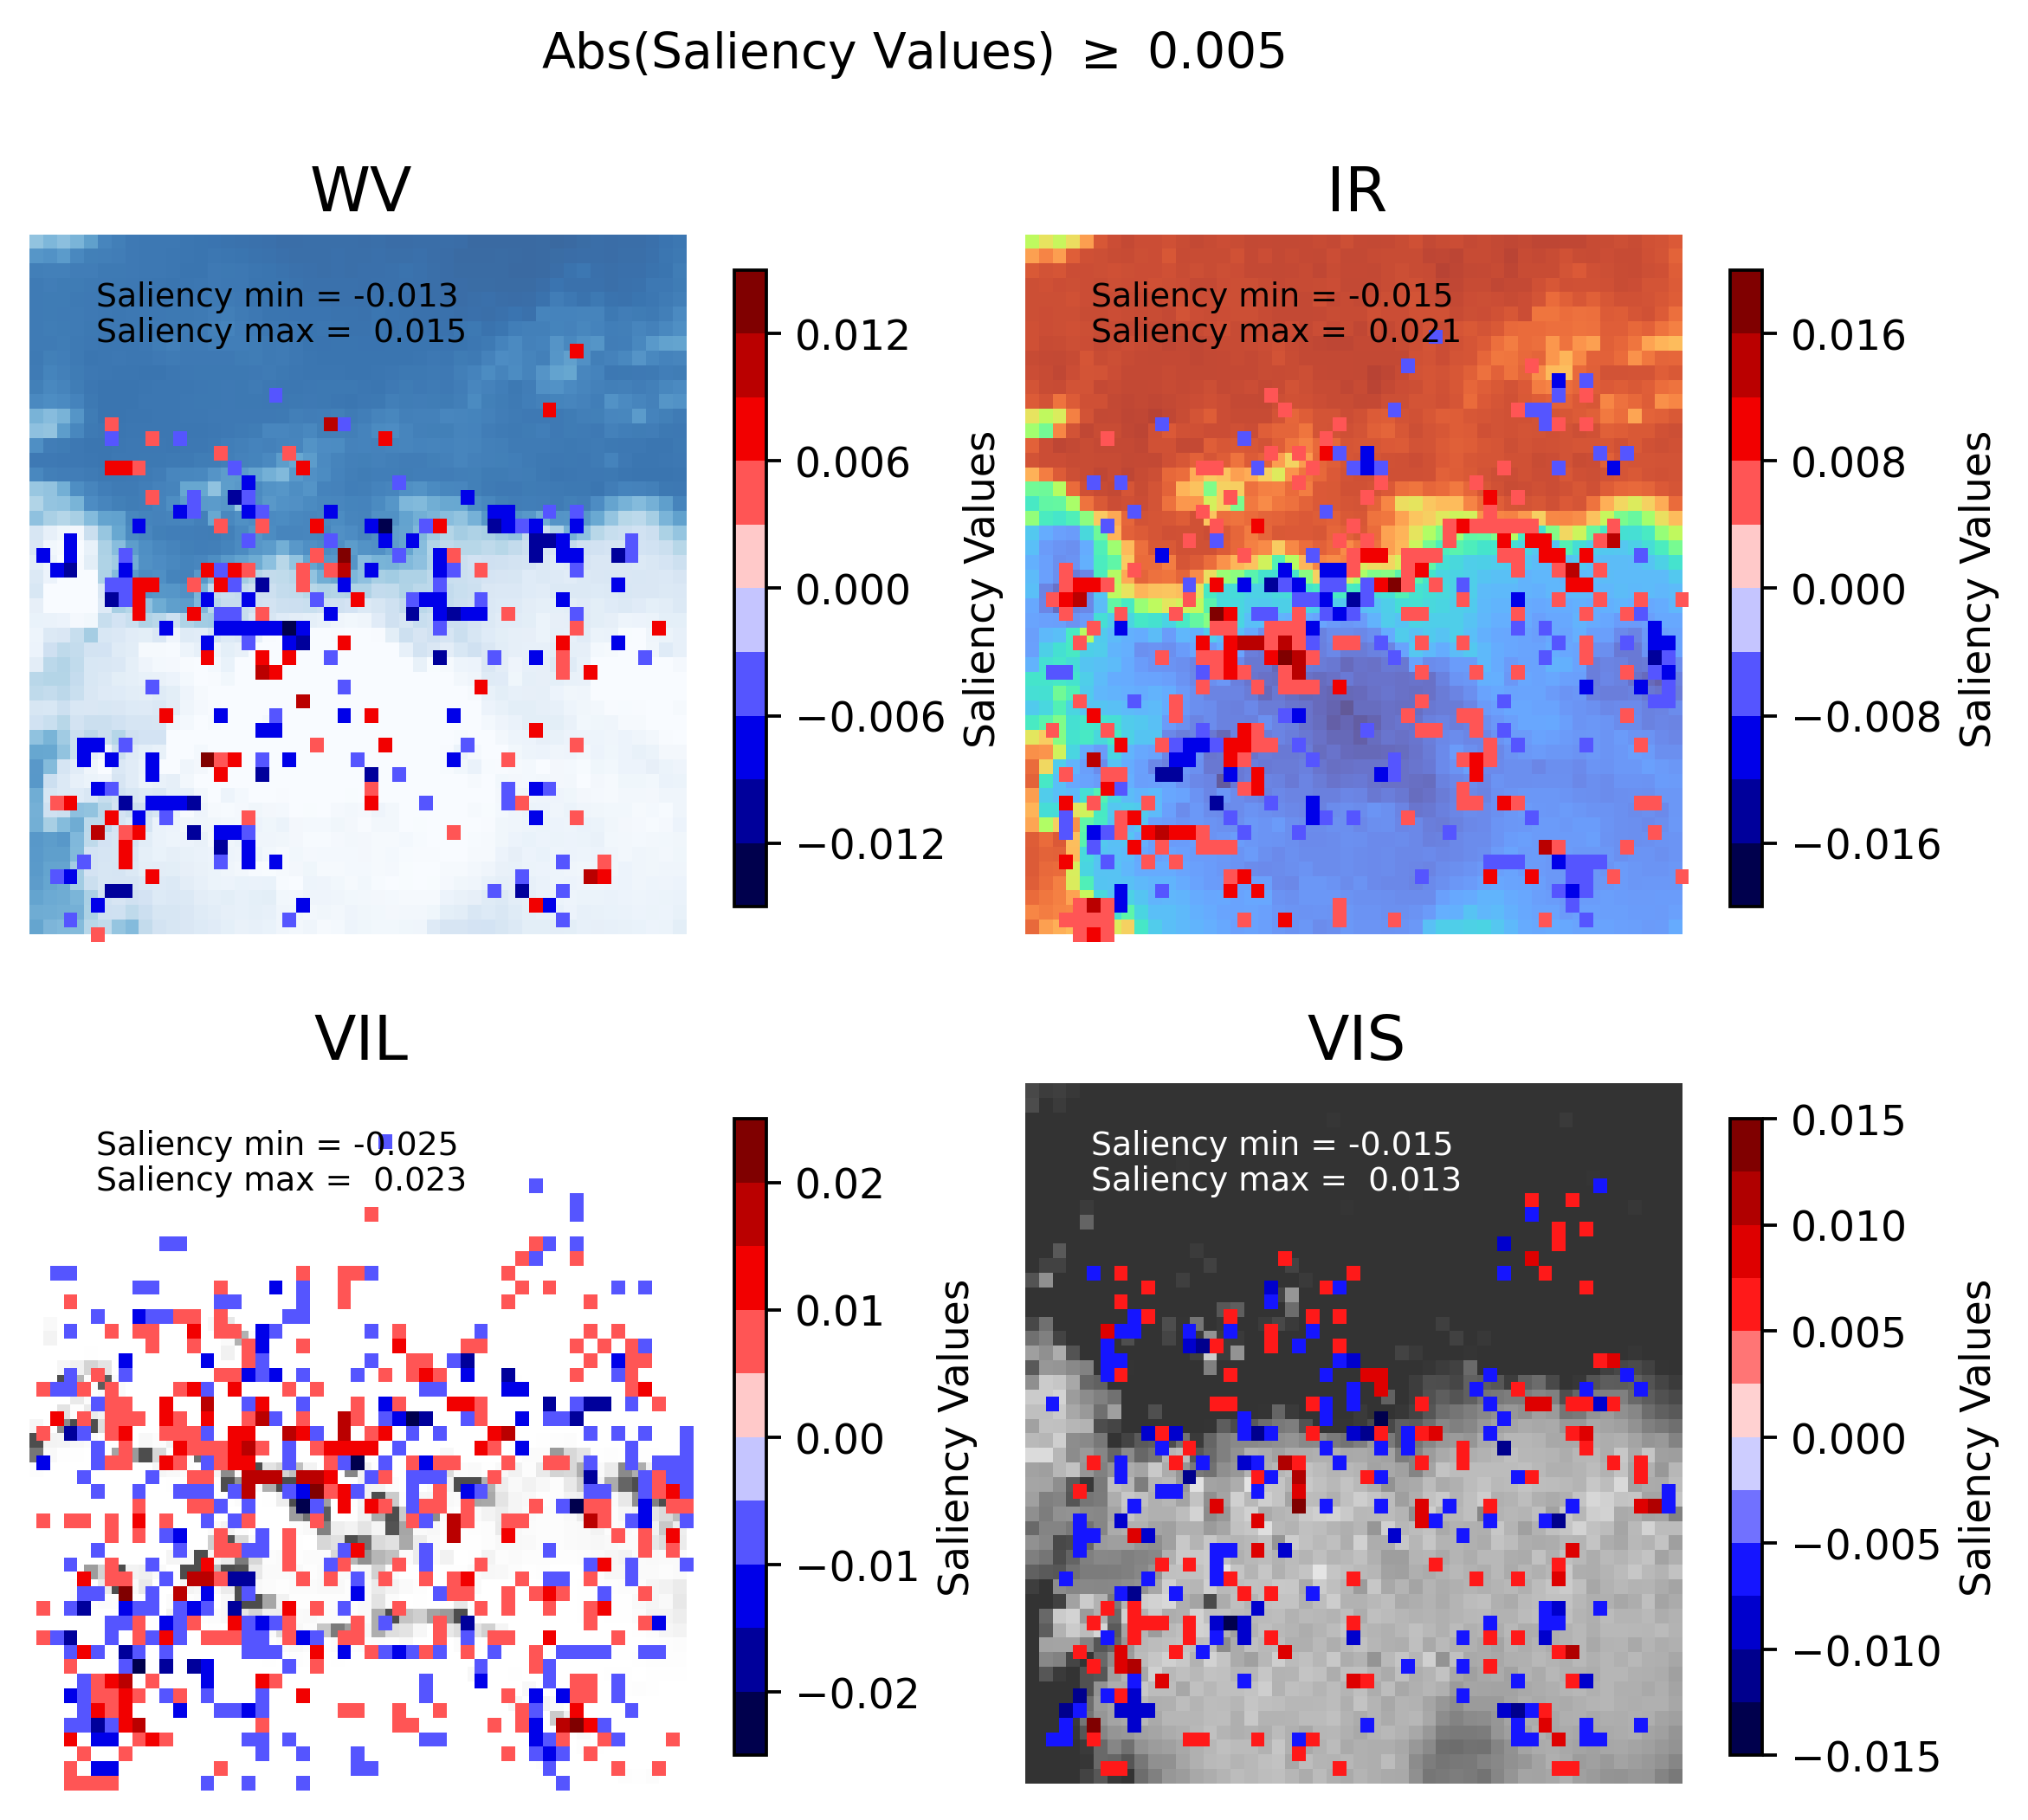

In [8]:
ax = make_plot(im, mask=saliency_map_class, mask_thresh=0.005, mode='Saliency')

Using `make_plot_saliency`, we plot the smoothed saliency map, which is slightly easier to analyze than the raw saliency map. We can see that cloud boundaries, higher VIL values, and lower IR values are sensitive regions for the CNN model. VIL has the highest saliency values indicating that changes in VIL can lead to the greatest change in the model prediction. This is consistent with VIL being the top features and the results we found in the SHAP notebook.

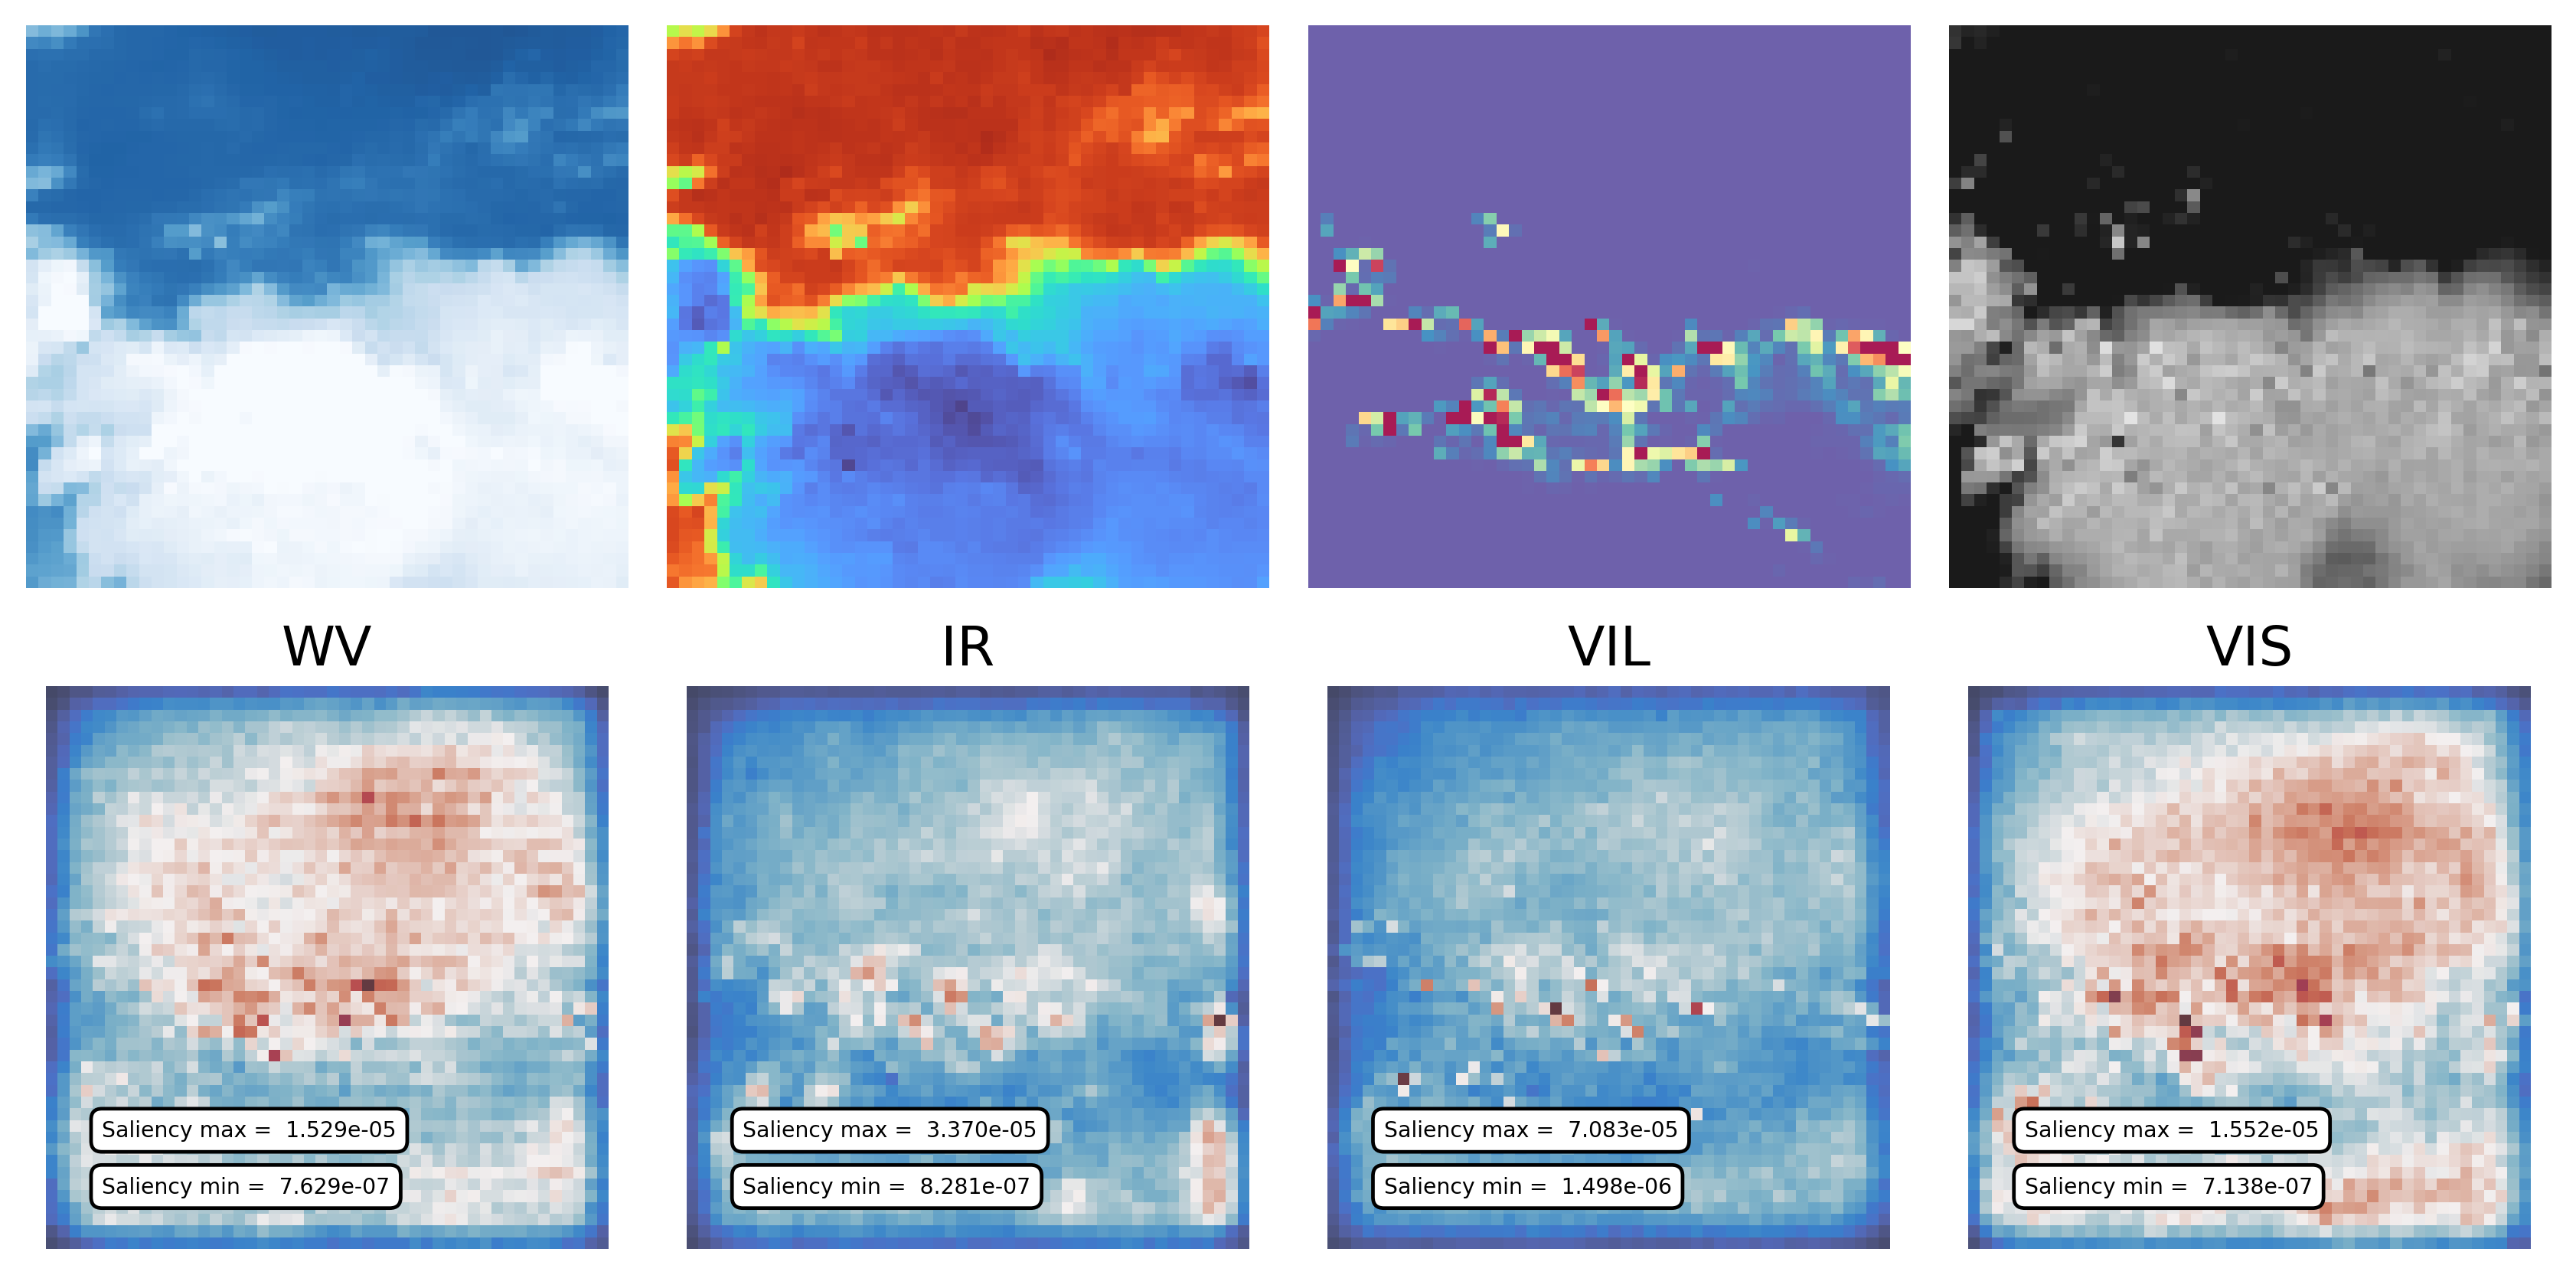

In [9]:
ax = make_plot_saliency(im, mask=smooth_saliency_class)

<div class="alert alert-block alert-info"><b>Question 1: </b> How would you use this output to explain the model prediction to your specific end-user for the trust-a-thon? How would that change if you were explaining to the other end user for your dataset?  </div>

<div class="alert alert-block alert-info"><b>Question 2: </b> Assuming you already completed the SHAP notebook, which method, SHAP vs. Saliency, do you find helps you better understand the CNN model? Which method might be more useful for explaining the model or predictions to your end-user? Make you compare the pros and cons of both methods.  </div>

### ii. Regression

In [10]:
# Compute the classification saliency maps
saliency_map_reg, smooth_saliency_reg = get_saliency(im, mode='regression')

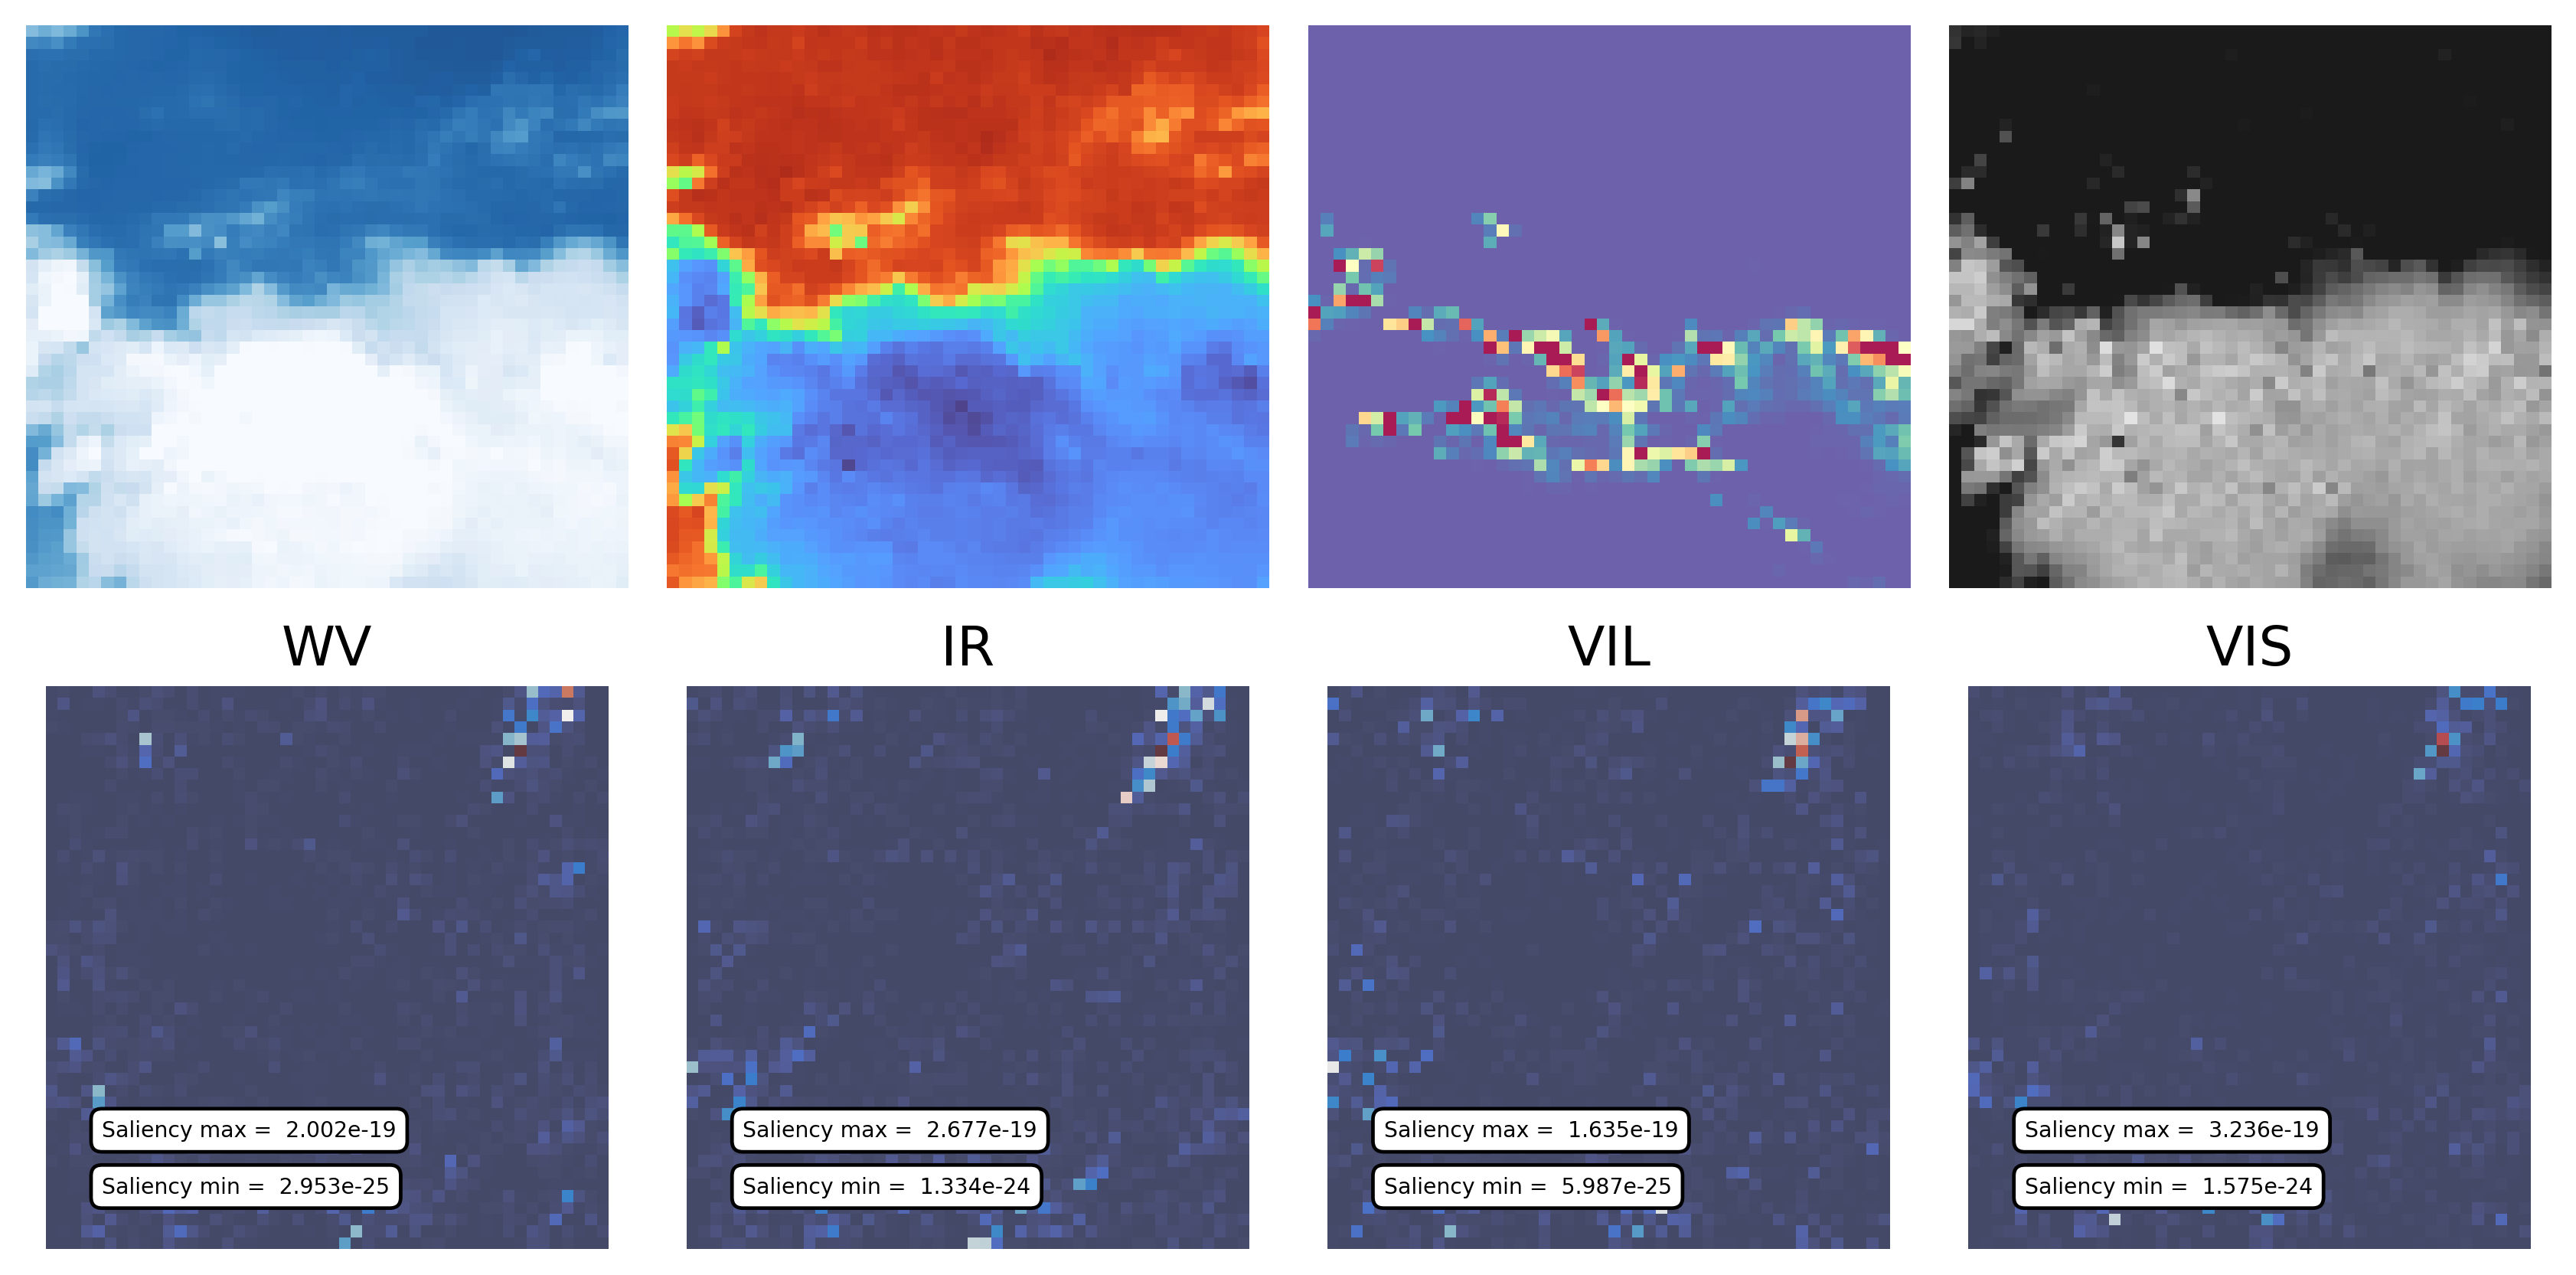

In [11]:
ax = make_plot_saliency(im, mask=smooth_saliency_reg)

The saliency values for the regression model are practically negliglible (on the order of $10^{-20}$ on the high end) and do not seem to have any sort of systematic location. This highlights one major drawback of saleincy methods, they only indentify parts of the image that are 'sensative' to the prediction. In other words, if these areas of the image changed value, it would change the prediction value. 

This method DOES NOT tell you "this region of the image lead to this much of the prediction". That question is better suited for Shap. 

## No Storm Example

As a contrasting example, we can consider a satellite image with very little meteorological activity. 

/Users/monte.flora/miniconda3/envs/ai2es/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


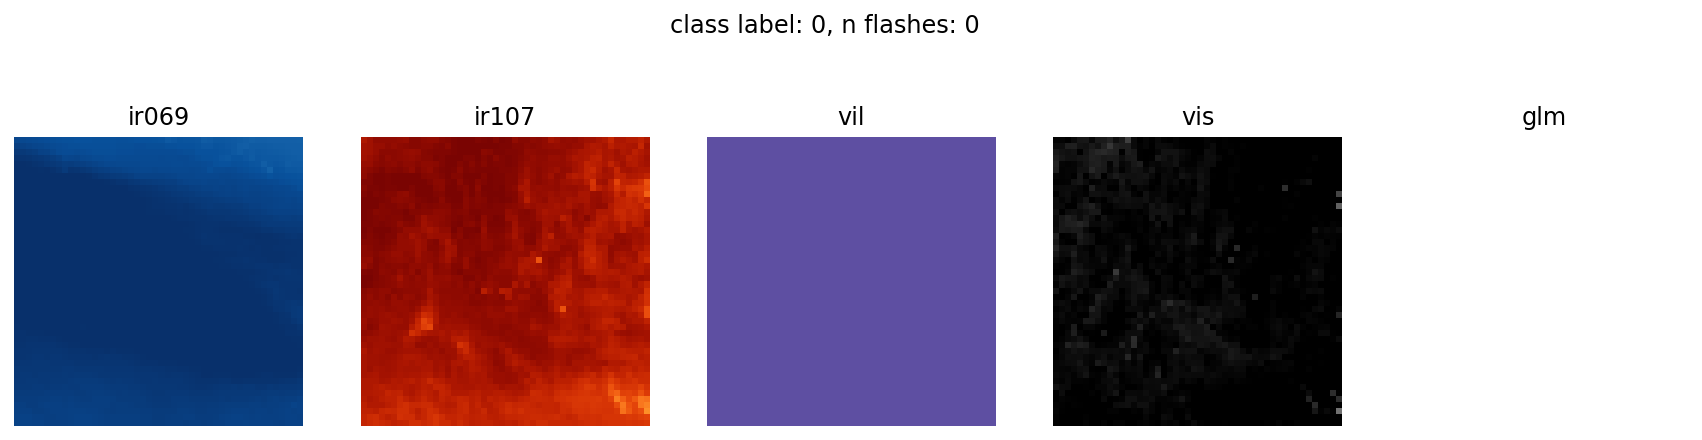

In [12]:
#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['R19072715377489'])

show_sample(ds_sample.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=0).features.values 

For this example, there are some clouds on the visible imagery, but we can see these are warm (IR says warm for most of the image), implying that they are mainly shallow clouds, which are not capable of producing lightning. 

### i. Classification
Below the shap values for the classification model for the no lightning event we chose. This is a confident prediction from the model that there is no lighting, the prediction is effectively 0. 

In [13]:
# Compute the classification saliency maps
saliency_map_class, smooth_saliency_class = get_saliency(im, mode='classification')

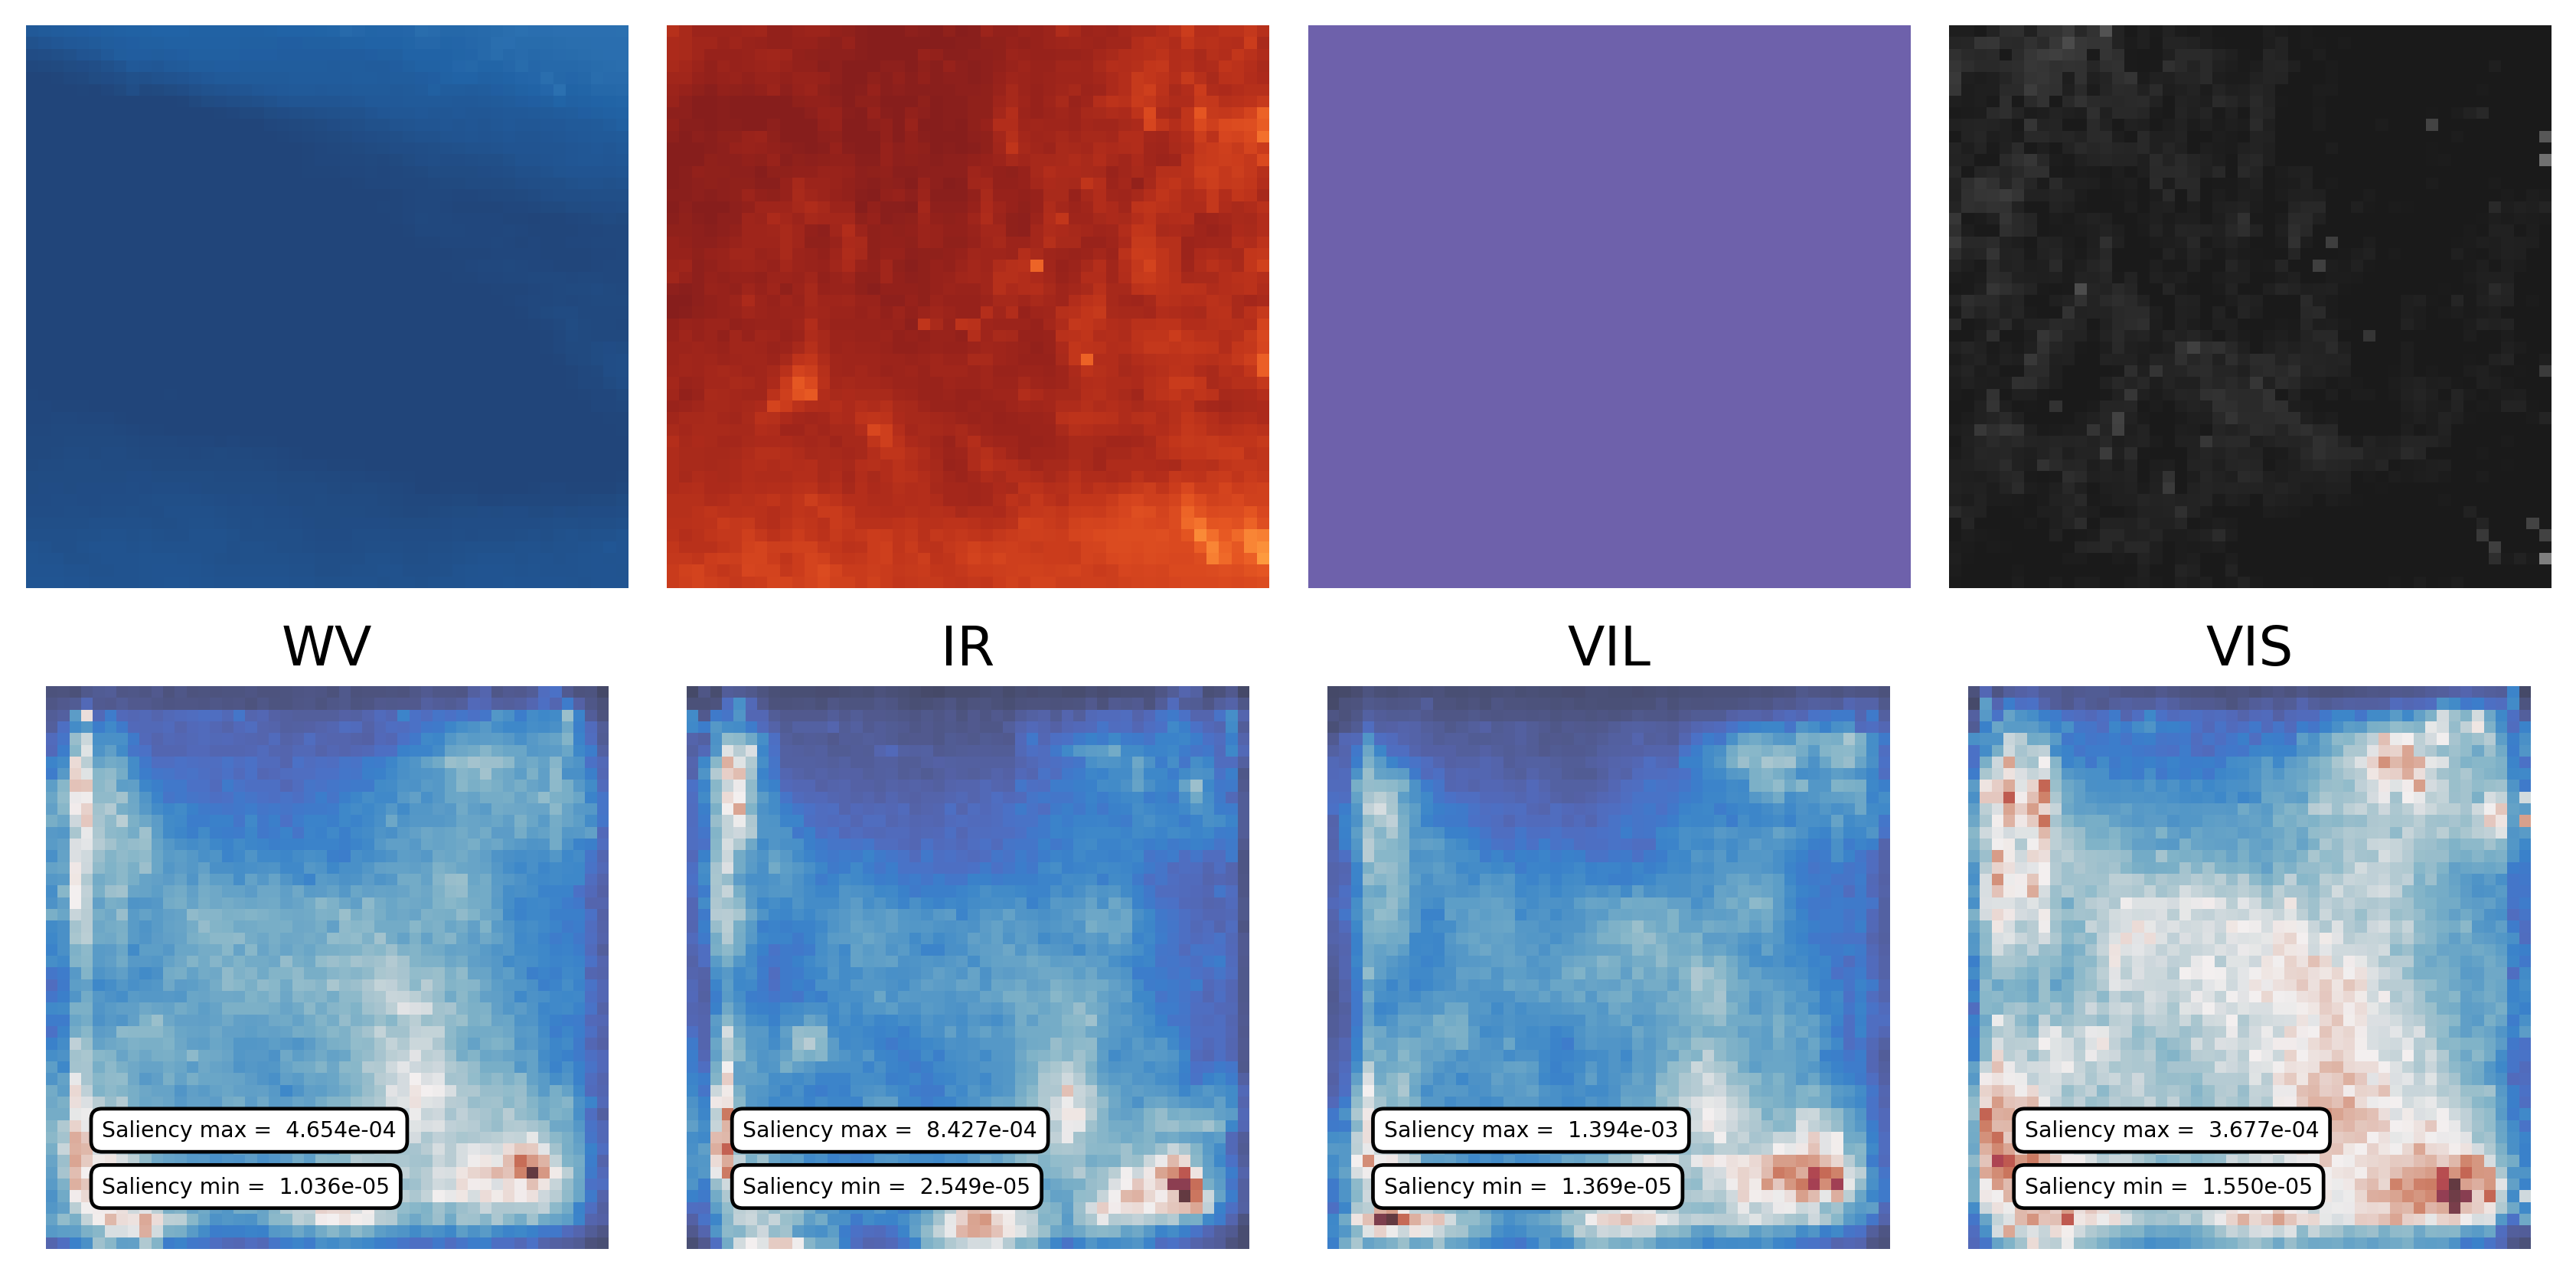

In [14]:
ax = make_plot_saliency(im,mask=smooth_saliency_class)

### ii. Regression

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Convert the following section back to code and run it to see how the SHAP values compare against the classification model for the same example. </div>

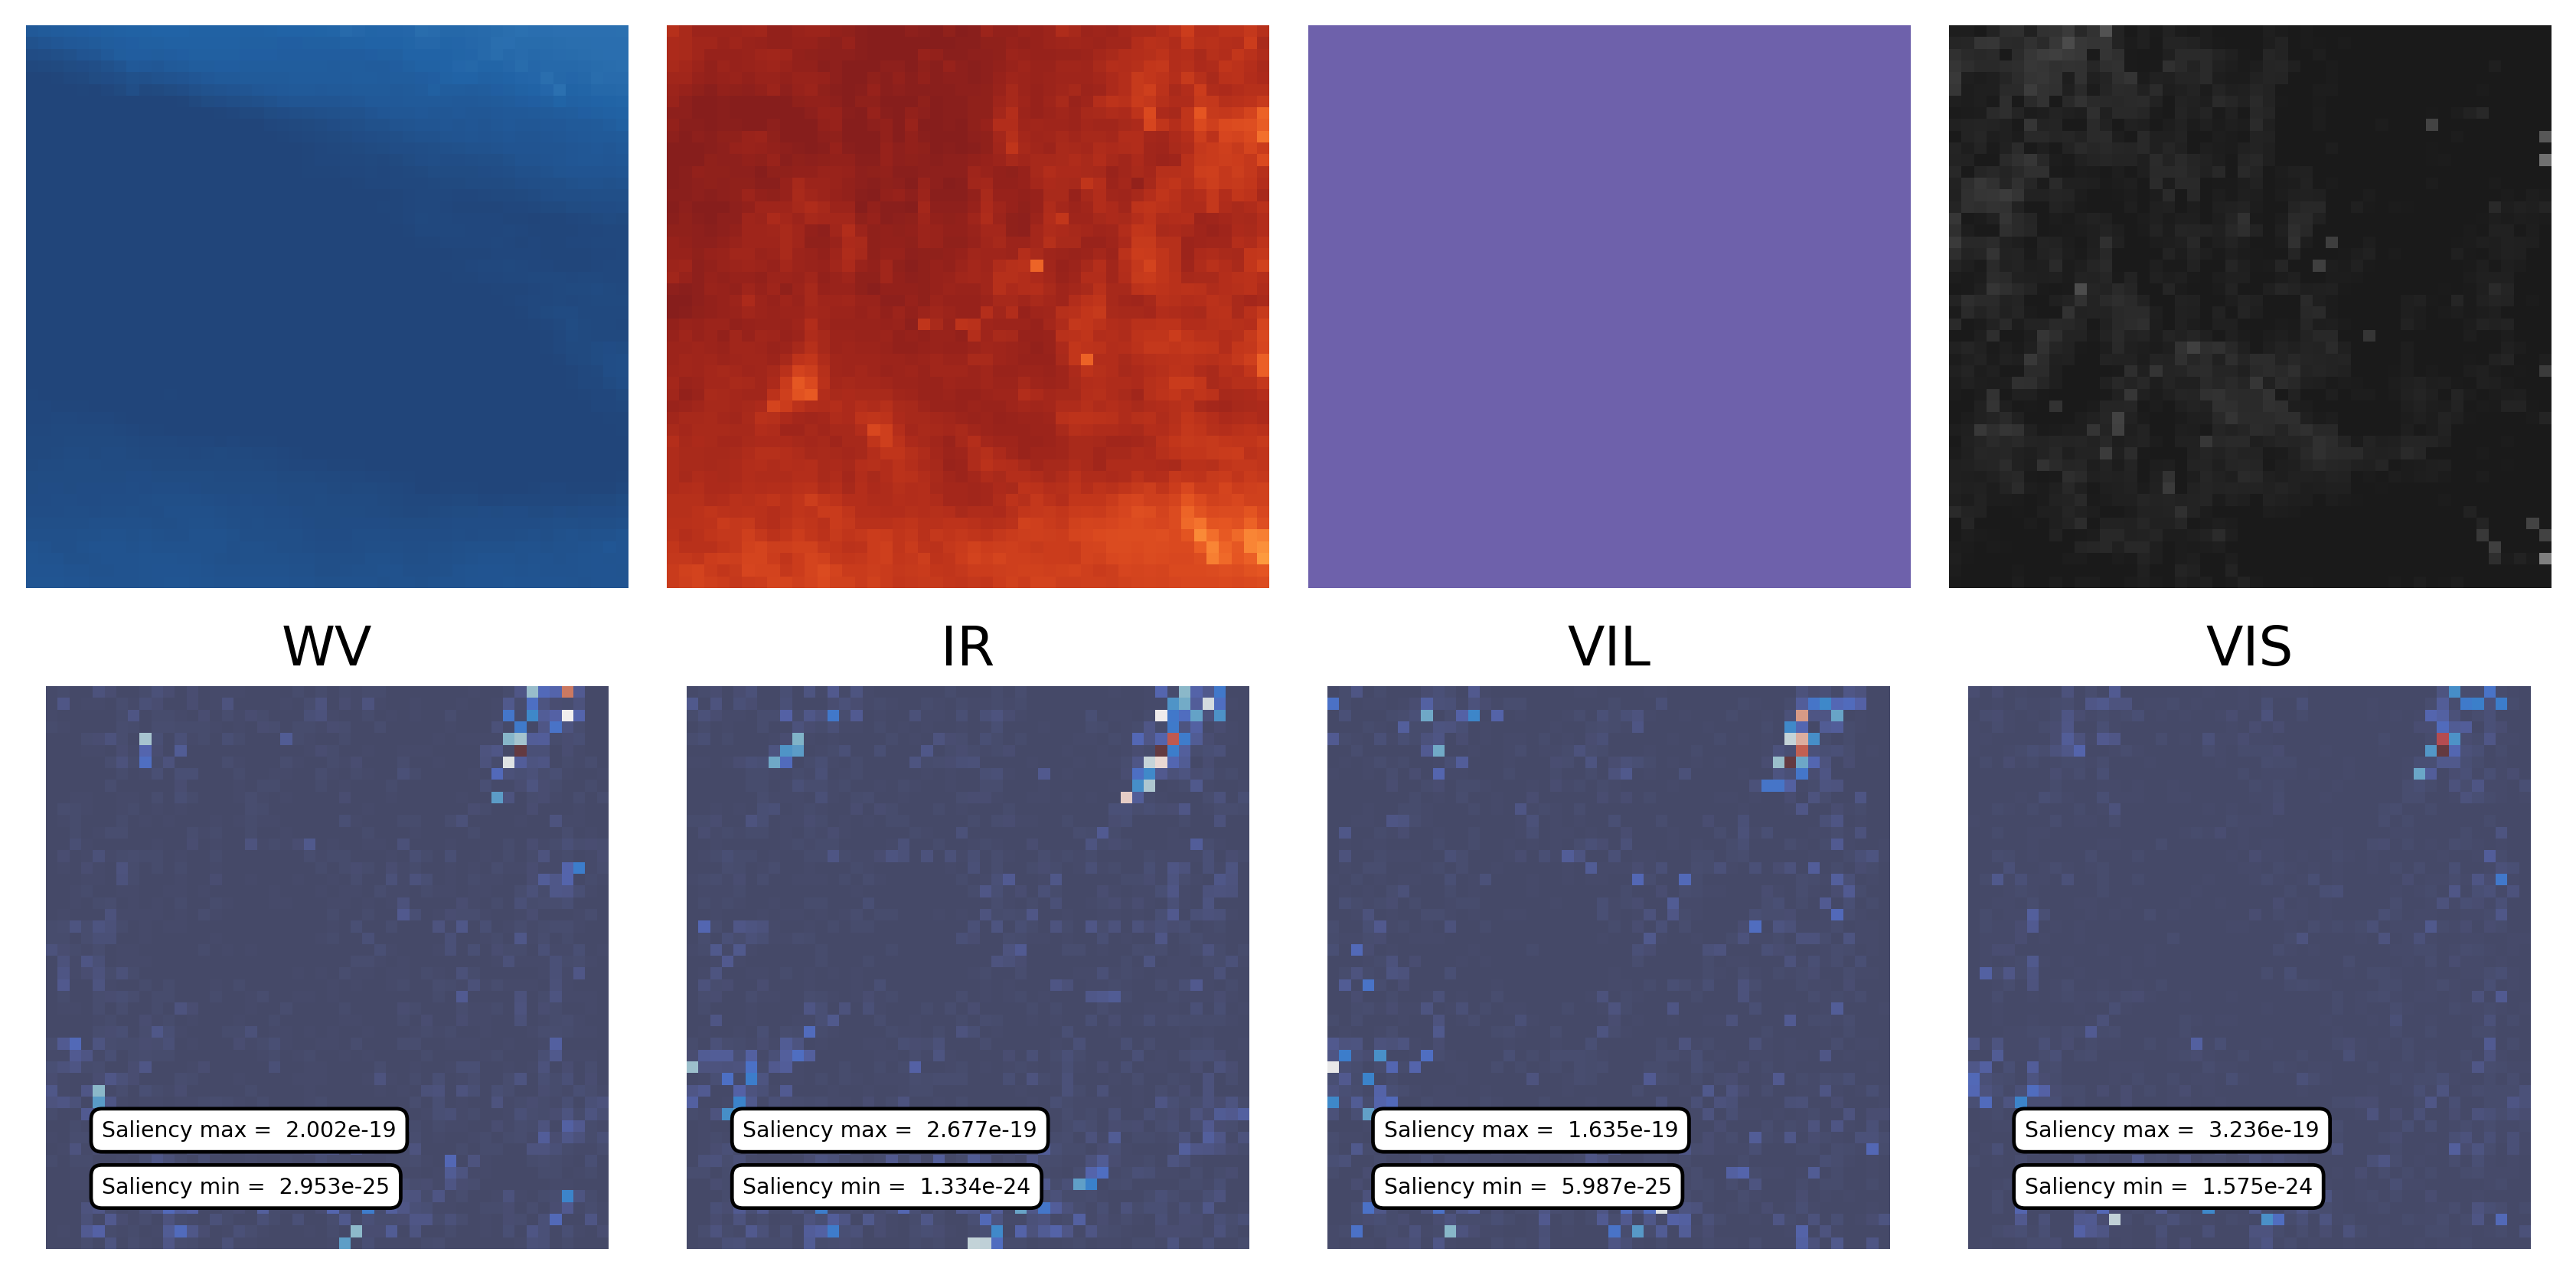

In [15]:
ax = make_plot_saliency(im, mask=smooth_saliency_reg)

## Task 2 . Using Inputs * Gradients to understand individual images

### Strong Convection Example

/Users/monte.flora/miniconda3/envs/ai2es/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


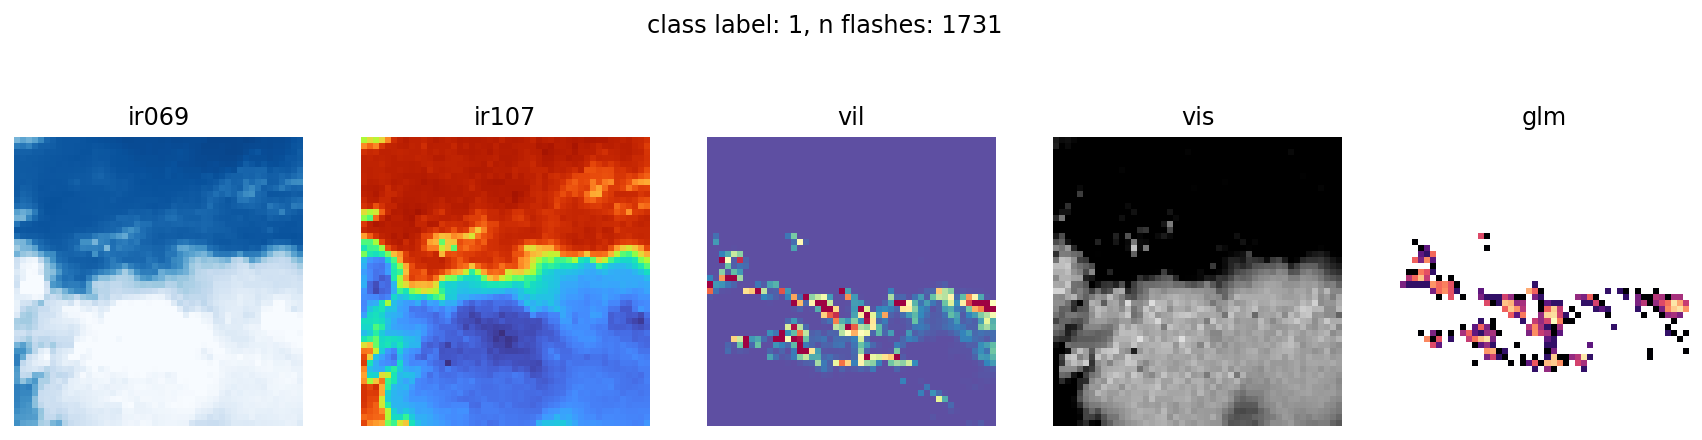

In [16]:
#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['S841009'])

show_sample(ds_sample.isel(n_samples=11))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=11).features.values 

In [17]:
# Compute the classification saliency maps
saliency_map_class, smooth_saliency_class = get_saliency(im, mode='classification')

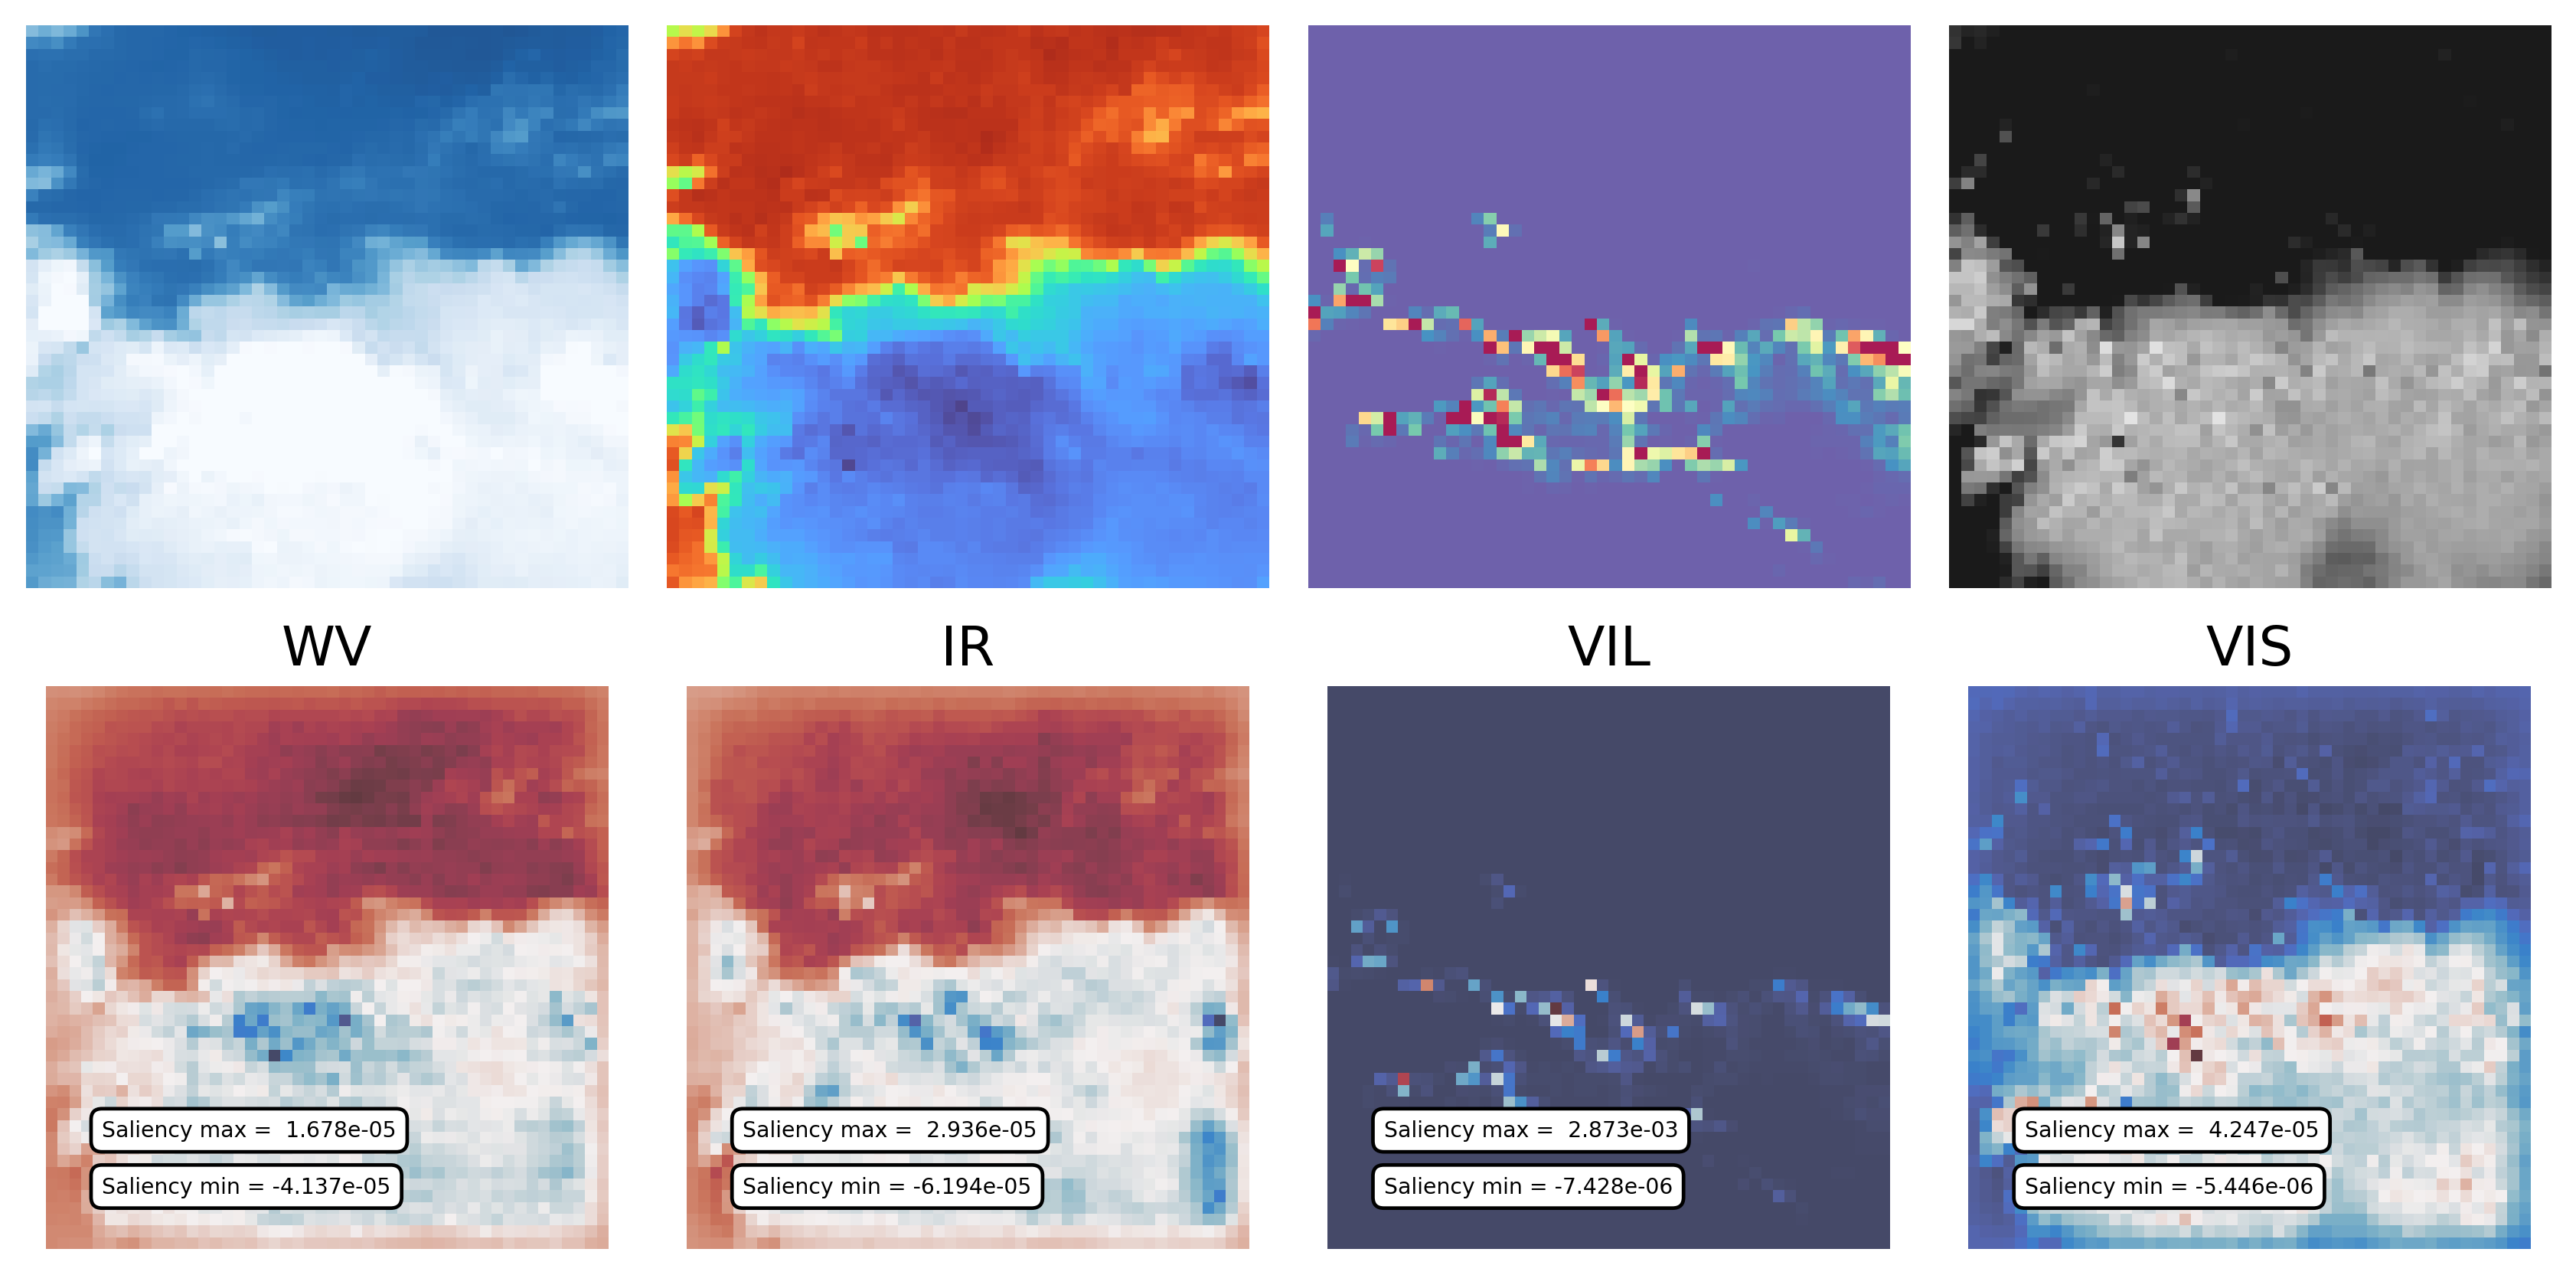

In [19]:
#Plot the smooth saliency 
ax = make_plot_saliency(im,mask=im*smooth_saliency_class)

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Explore the inputs*gradients for the regression task and for the non-storm example. </div>


### How to select new cases

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Explore different examples in the dataset and use the Saliency values to better understand the models.  </div>


we only showed two examples above, but there are more than 100,000 images to look at in this dataset. To choose a new example you can look up new storms by index if you want. 


<div class="alert alert-block alert-success"><b>User-Defined Options</b> To explore different examples, you'll have to declare the example index (<b>idx</b>) and whether you are using the classification (mode = 'classification') or regression model (mode = 'regression') </div>


In [20]:
# USER-DEFINED OPTIONS ----------------------
idx = 42 
mode = 'classification'
#mode = 'regression'
#--------------------------------------------

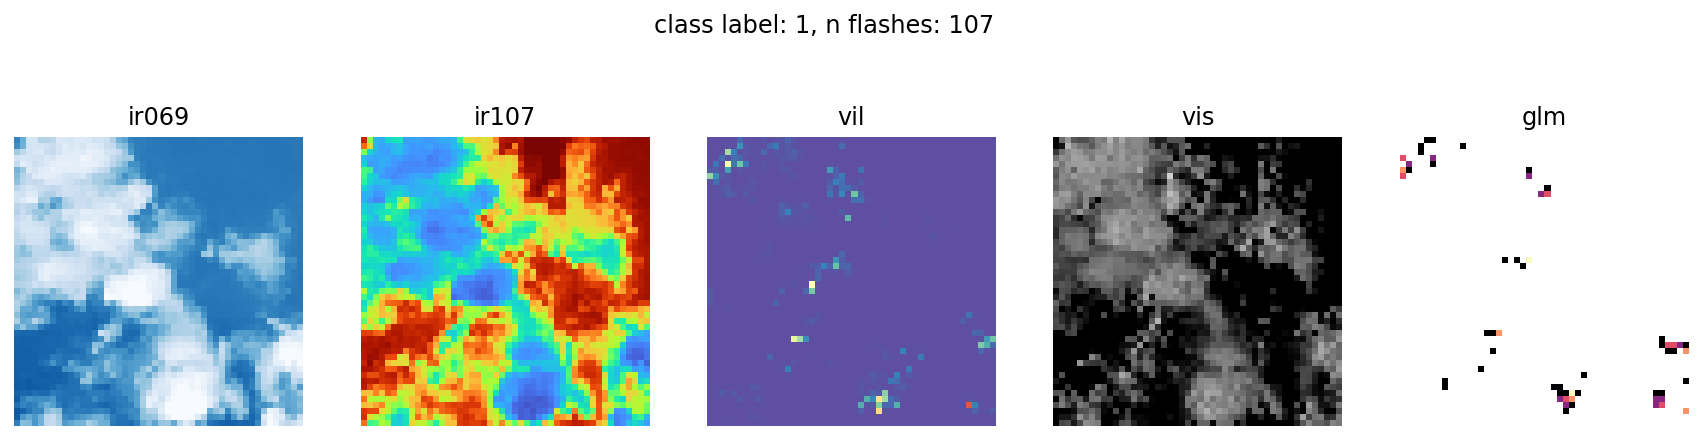

In [21]:
ds_sample = ds_val.isel(n_samples=idx)

#plot this example with a plotter function I have defined 
show_sample(ds_sample)

#store this image to do the XAI on 
im = ds_sample.features.values 

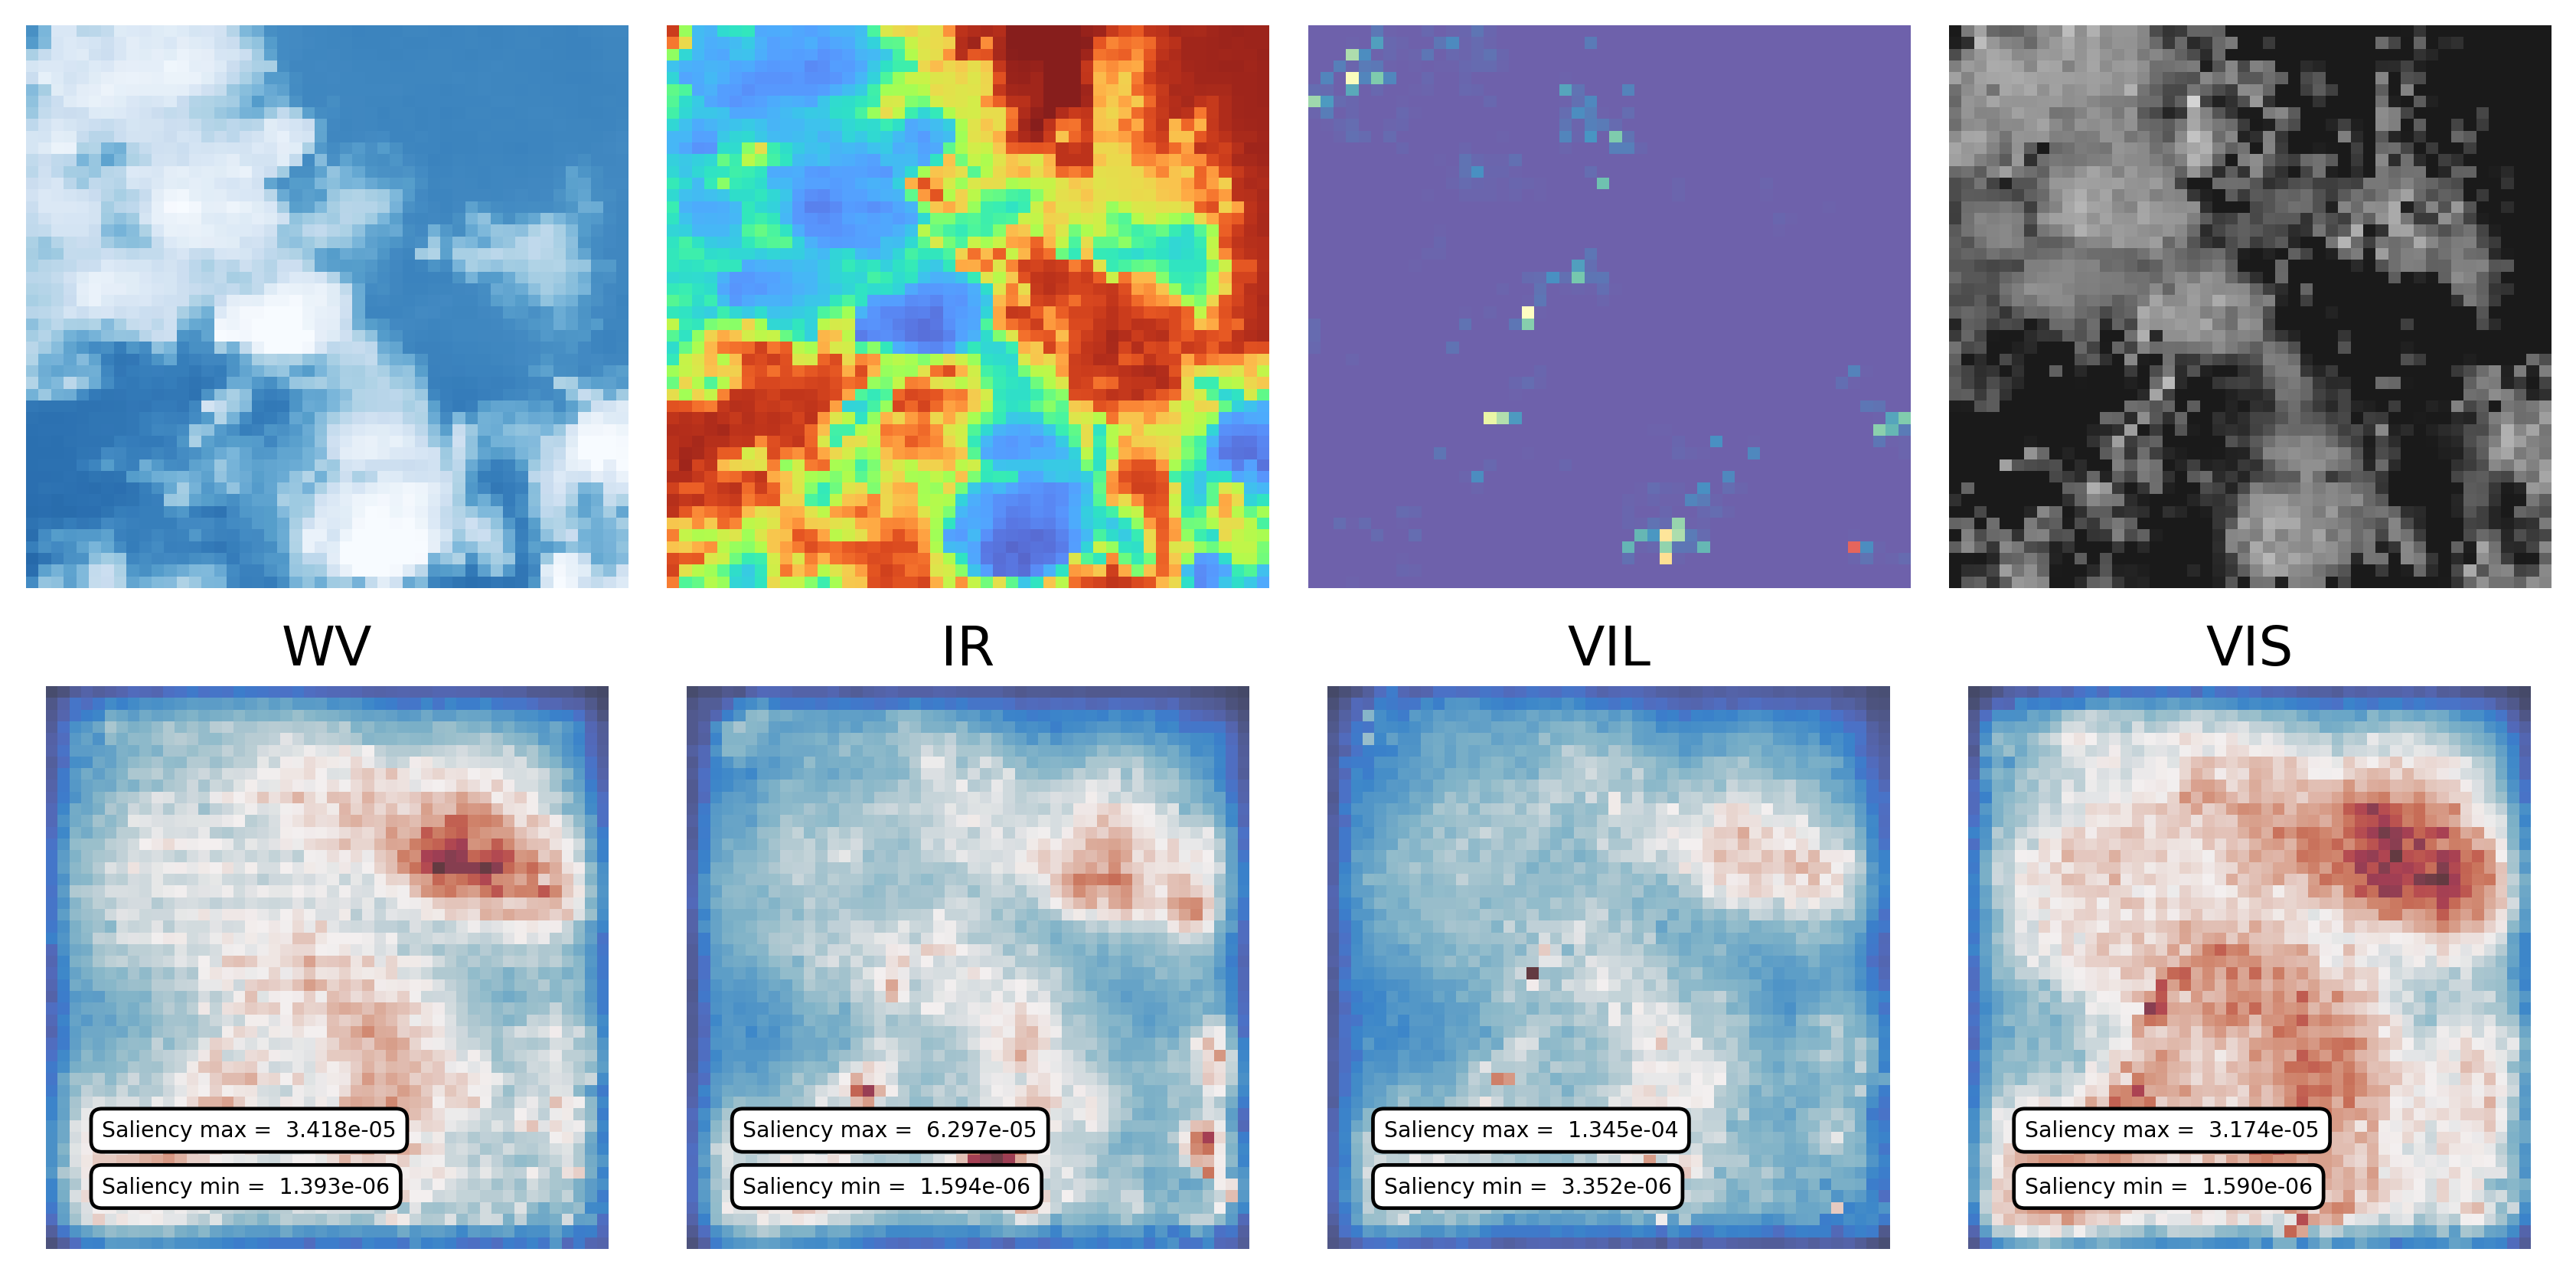

In [23]:
# Compute the classification saliency maps
saliency_map, smooth_saliency = get_saliency(im, mode=mode)
ax = make_plot_saliency(im, mask=smooth_saliency)

Then what if you wanted a different time step of this same 'storm system'

In [24]:
#choose 1 'storm' to show in examples
ds_sample_all_time = ds_val.isel(n_samples=ds_val.groupby('id').groups[str(ds_sample.id.values)])
ds_sample_all_time

<xarray.Dataset>
Dimensions:         (n_samples: 12, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 'R19072723347550' ... 'R19072723347550'
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2019-07-26T23:10:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

You can see now there is 12 samples, which are all the time steps of this one storm scene 

/Users/monte.flora/miniconda3/envs/ai2es/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


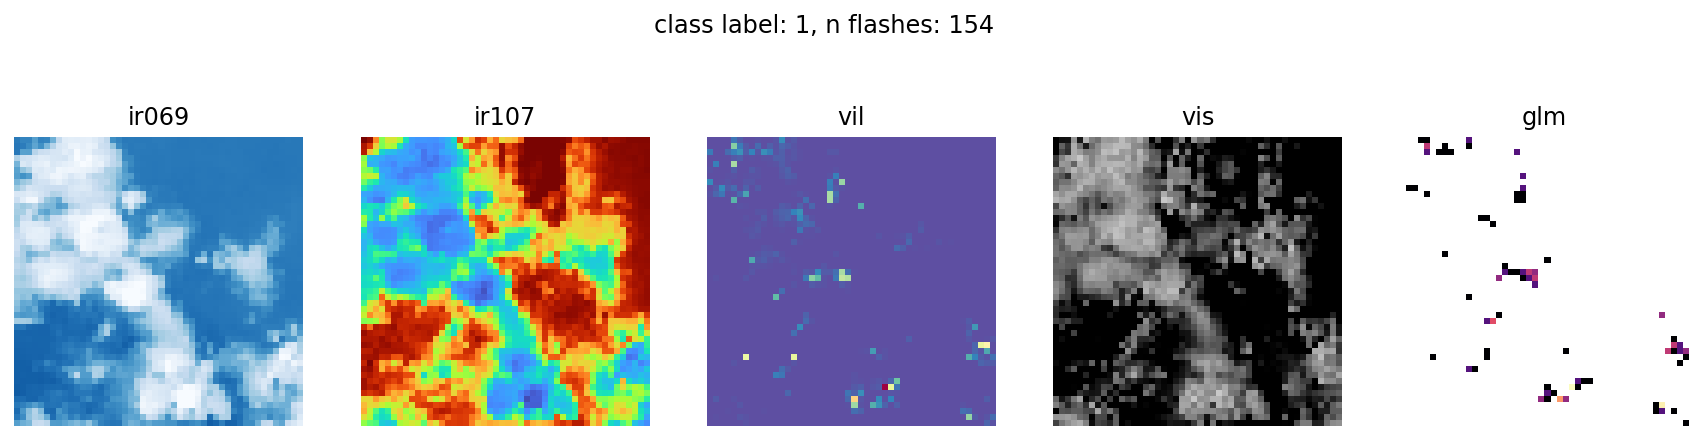

In [25]:
#plot this example with a plotter function I have defined 
show_sample(ds_sample_all_time.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample_all_time.isel(n_samples=0).features.values 